# neandertools tutorial

This notebook demonstrates the two main ways to use **neandertools** on the Rubin Science Platform:

1. **Low-level** — extract cutouts from known `(visit, detector)` pairs directly via `cutouts_from_butler`
2. **High-level** — run the full asteroid tracking pipeline with `AsteroidCutoutPipeline`

Both require an active connection to the Butler repository and the LSST software stack.

## Setup

In [1]:
# If neandertools is not yet installed in your RSP environment:
# !pip install -e /path/to/neandertools --quiet

import matplotlib.pyplot as plt
from IPython.display import Image, display

import neandertools as nt
from neandertools import AsteroidCutoutPipeline, cutouts_from_butler

---
## Part 1 — Full asteroid tracking pipeline

`AsteroidCutoutPipeline` automates the complete workflow:

1. Query JPL Horizons for the ephemeris
2. Build sky-search polygons along the predicted track
3. Find all overlapping Butler images
4. Extract a cutout centred on the interpolated asteroid position at each epoch
5. Render an animated GIF with the asteroid fixed at the centre

Frames where the target falls on a trimmed image border are automatically discarded.

### 1a — Create and run the pipeline

In [7]:
pipeline = AsteroidCutoutPipeline(
    target="1991 SJ",
    start="2024-11-25",
    end="2024-11-28",
    dr="dp1",
    collection="LSSTComCam/DP1",
    cutout_size=200,
    step="12h",
)

In [8]:
gif_path = pipeline.run(
    output_path="1991SJ.gif",
    warp_common_grid=True,   # align all frames on a common sky grid
    show_ne=True,            # draw a North/East compass indicator
    match_background=True,   # subtract per-frame sky background
    match_noise=True,        # divide by per-frame RMS (SNR display)
    frame_duration_ms=500,
)
print(f"GIF written to: {gif_path}")
print(f"Frames kept: {len(pipeline.cutouts)}")

GIF written to: 1991SJ.gif
Frames kept: 10


### 1b — Display the GIF inline

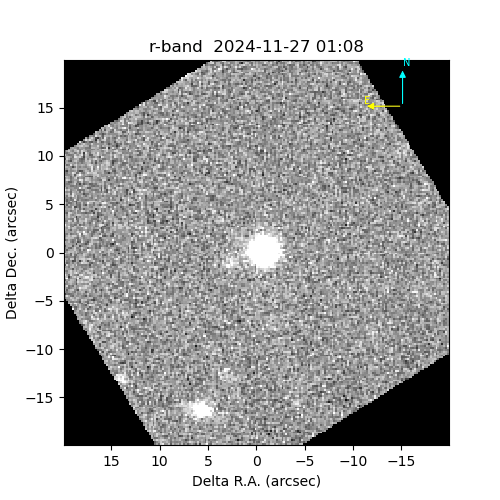

In [9]:
display(Image(filename=str(gif_path)))

### 1c — Contact-sheet grid

`pipeline.grid()` displays all frames side-by-side using the same display options as the GIF.
Call it after `run()` — it reuses the already-extracted cutouts.

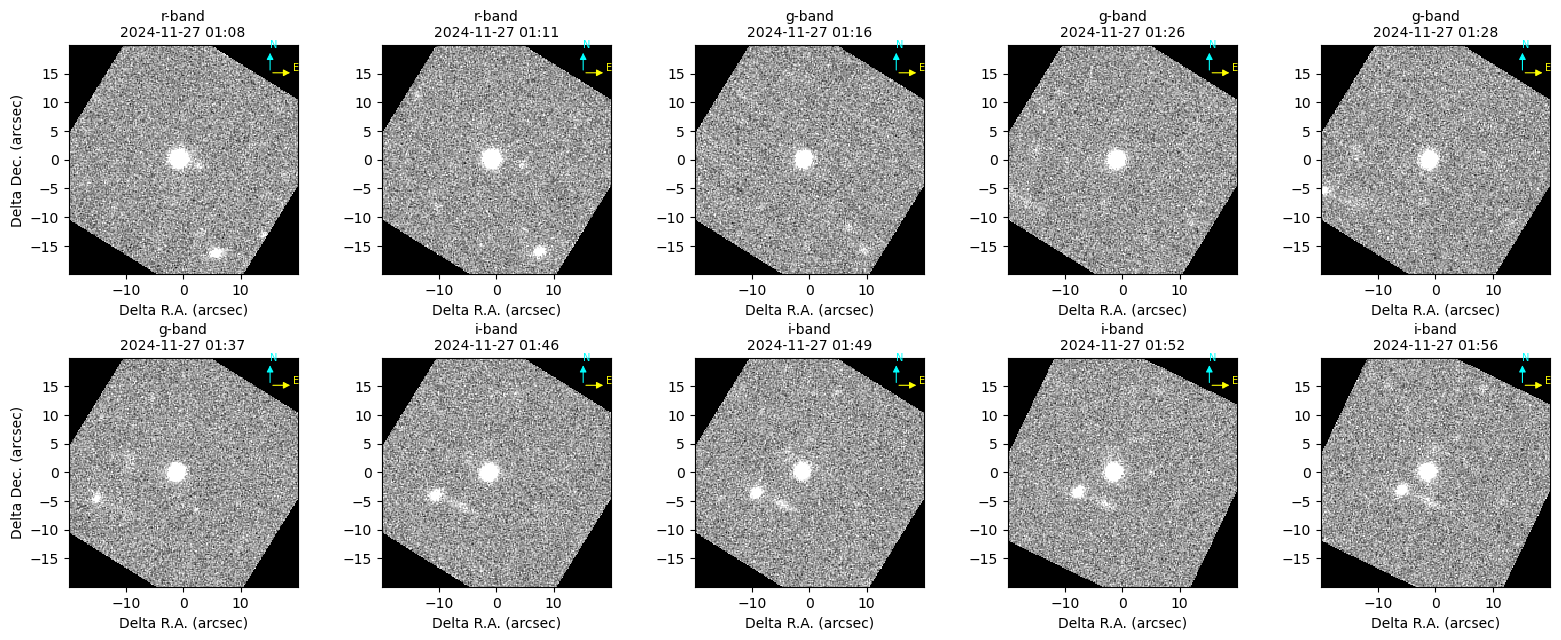

In [10]:
fig, axes = pipeline.grid(
    ncols=5,
    warp_common_grid=True,
    show_ne=True,
    match_background=True,
    match_noise=True,
)
# Save the grid separately if needed
fig.savefig("1991SJ_grid.png", dpi=150, bbox_inches="tight")

---
## Part 2 — Tips

### Equivalent command-line call

The pipeline above is identical to:

```bash
python run_pipeline.py "1991 SJ" 2024-11-25 2024-11-28 \
    --output 1991SJ.gif --warp --grid --cutout-size 200 \
    --match-noise --show-ne --step 12h
```

The CLI is the recommended option when the notebook kernel is unstable.

### Choosing parameters

| Parameter | Guidance |
|---|---|
| `cutout_size` | 100–200 px works well for most main-belt objects. Increase for fast-moving NEOs. |
| `step` | `12h` is usually sufficient. Use `1h` only if you suspect the ephemeris grid is too coarse for the object's motion. |
| `warp_common_grid` | Recommended for GIFs — aligns frames so the asteroid is pinned at centre and stars drift. Requires LSST warp modules. |
| `match_background` | Almost always on. Removes sky background differences between epochs. |
| `match_noise` | Useful for very faint targets — normalises each frame to the same noise level. |
| `polygon_widening_arcsec` | Default 2 arcsec is conservative. Increase if images are missed; decrease to reduce false-positive candidates. |

### Inspecting intermediate results

After `run()` the pipeline object retains all intermediate data:

In [11]:
# Ephemeris (from JPL Horizons)
eph = pipeline.ephemeris
print("Ephemeris points:", len(eph["ra_deg"]))
print("RA range: {:.4f} – {:.4f} deg".format(eph["ra_deg"].min(), eph["ra_deg"].max()))
print("Dec range: {:.4f} – {:.4f} deg".format(eph["dec_deg"].min(), eph["dec_deg"].max()))

# Search polygons built from the ephemeris
print("\nSearch polygons:", len(pipeline.polygons))

# Kept cutouts and their metadata
print("\nKept frames:", len(pipeline.cutouts))
for meta in pipeline.frame_metadata:
    print(f"  {meta['band']}-band  {meta['time'].utc.iso[:16]}")

Ephemeris points: 7
RA range: 37.8919 – 38.4976 deg
Dec range: 6.1909 – 6.2906 deg

Search polygons: 1

Kept frames: 10
  r-band  2024-11-27 01:08
  r-band  2024-11-27 01:11
  g-band  2024-11-27 01:16
  g-band  2024-11-27 01:26
  g-band  2024-11-27 01:28
  g-band  2024-11-27 01:37
  i-band  2024-11-27 01:46
  i-band  2024-11-27 01:49
  i-band  2024-11-27 01:52
  i-band  2024-11-27 01:56
